## Imports

In [ ]:
!git clone https://github.com/rmnigm/qber-forecasting.git

In [ ]:
!pip install catboost

In [5]:
import collections
import math
import os
import pathlib
import random


import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import scipy.stats as sps

import statsmodels as sm

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

In [6]:
seed = 123456
random.seed(seed)
np.random.seed(seed)

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
columns = {
    1: 'blockId',
    2: 'frameIdx',
    3: 'frameError',
    4: 'byDecoyEst',
    5: 'byDecoyZ',
    6: 'byVacuumZ',
    7: 'nmuSend',
    8: 'nnuSend',
    9: 'nlSend',
    10: 'nmuReg',
    11: 'nnuReg',
    12: 'nlReg',
    13: 'roundDistribution',
    14: 'maintenanceFlag',
    16: 'ema_est',
    17: 'ema_f_ec',
    19: 'vema_est',
    20: 'vema_f_ec',
    22: 'ml_est',
    23: 'ml_f_ec',
    25: 'phys_est',
    26: 'phys_f_ec',
}

In [10]:
data = pl.read_csv('/content/drive/MyDrive/Datasets/qber/frames_errors_12-03.csv', has_header=False)

In [11]:
data = data[:, [k-1 for k in columns.keys()]]
data.columns = list(columns.values())
data = data.select(
    pl.col('vema_f_ec').cast(float).alias('vema_f_ec'),
    pl.col('phys_f_ec').cast(float).alias('phys_f_ec'),
    pl.col('ema_f_ec').cast(float).alias('ema_f_ec'),
    pl.col('ml_f_ec').cast(float).alias('ml_f_ec'),
    pl.col('vema_est').cast(float).alias('vema_est'),
    pl.col('phys_est').cast(float).alias('phys_est'),
    pl.col('ema_est').cast(float).alias('ema_est'),
    pl.col('ml_est').cast(float).alias('ml_est'),
    pl.col('frameError').alias('qber_mu'),
    pl.col('byDecoyEst').alias('qber_prob_model'),
    pl.col('byDecoyZ').alias('qber_nu_1'),
    pl.col('byVacuumZ').alias('qber_nu_2'),
    (pl.col('nmuReg') /  pl.col('nmuSend')).alias('q_mu'),
    (pl.col('nnuReg') /  pl.col('nnuSend')).alias('q_nu_1'),
    (pl.col('nlReg') /  pl.col('nlSend')).alias('q_nu_2'),
    pl.col('maintenanceFlag').alias('maintenance'),
    (pl.col('frameError') - pl.col('ml_est')).abs().alias('ml_err'),
    (pl.col('frameError') - pl.col('ema_est')).abs().alias('ema_err'),
    (pl.col('frameError') - pl.col('vema_est')).abs().alias('vema_err'),
    (pl.col('frameError') - pl.col('phys_est')).abs().alias('phys_err'),
)
ts = data['qber_mu']
ema_ts = data['ema_est']

In [183]:
def calculate_offset_limit(offset, limit, length) -> tuple[int, int]:
    if offset is None:
      offset = 0
    else:
      offset = offset if offset >= 1 else int(offset * length)
    if limit is None:
      limit = length
    else:
      limit = limit if limit >= 1 else int(limit * length)
    return offset, limit

In [12]:
def build_from_dataframe(
    data: pl.DataFrame,
    window_size: int,
    dtype: np.dtype = np.float32,
    columns: list[str] | None = None,
    offset: int | float = None,
    limit: int | float = None) -> tuple[np.ndarray, np.ndarray]:
    length = len(data)
    offset, limit = calculate_offset_limit(offset, limit, length)
    columns = columns or data.columns
    data = (
        data
        .select(columns)
        .slice(offset, limit)
    )
    data_array = data.to_numpy()
    dataset = np.lib.stride_tricks.sliding_window_view(
        data_array,
        window_size + 1,
        axis=0
        )
    return dataset

In [165]:
feature_columns = [
    'qber_mu',
    # 'q_mu',
    # 'q_nu_1',
    # 'q_nu_2',
    'maintenance',
]

window_size = 7

In [166]:
train_data = build_from_dataframe(data=data, window_size=window_size, limit=0.75, columns=feature_columns)
test_data = build_from_dataframe(data=data, window_size=window_size, offset=0.75, columns=feature_columns)

train_x, train_y = train_data[:, :, :-1], train_data[:, 0, -1]
test_x, test_y = test_data[:, :, :-1], test_data[:, 0, -1]

In [167]:
full_data = build_from_dataframe(data=data, window_size=window_size, columns=feature_columns)
X, y = full_data[:, :, :-1], full_data[:, 0, -1]

In [169]:
import scipy.stats as ss

In [184]:
data[['qber_mu', 'qber_prob_model', 'qber_nu_1', 'qber_nu_2', 'q_mu', 'q_nu_1', 'q_nu_2']].corr()

qber_mu,qber_prob_model,qber_nu_1,qber_nu_2,q_mu,q_nu_1,q_nu_2
f64,f64,f64,f64,f64,f64,f64
1.0,-0.071362,0.025059,0.003316,-0.217253,-0.232522,-0.217898
-0.071362,1.0,0.198341,0.184253,-0.115986,-0.130453,-0.129976
0.025059,0.198341,1.0,0.496225,-0.341003,-0.367585,-0.34922
0.003316,0.184253,0.496225,1.0,-0.372281,-0.45833,-0.458868
-0.217253,-0.115986,-0.341003,-0.372281,1.0,0.91173,0.749103
-0.232522,-0.130453,-0.367585,-0.45833,0.91173,1.0,0.918665
-0.217898,-0.129976,-0.34922,-0.458868,0.749103,0.918665,1.0


In [185]:
ss.mannwhitneyu(
    data['qber_mu'].filter(data['maintenance'] == 0),
    data['qber_mu'].filter(data['maintenance'] == 1)
    )

MannwhitneyuResult(statistic=25008263.0, pvalue=1.0563451537565548e-18)

## Modelling

In [171]:
class FeatureExtractor:
    def __init__(self, binmask=None):
        self.eps = 1e-10
        self.binmask = binmask

    def __call__(self, x):
        if self.binmask is not None:
            binary_x = x[self.binmask, :]
            x = x[~self.binmask, :]
        latest = x[:, -1]
        means = x.mean(axis=1)
        medians = np.median(x, axis=1)
        stds = x.std(axis=1)
        deltas = latest / (means + self.eps)
        diffs = x.max(axis=1) - x.min(axis=1)
        target_lags = x[0]
        occurences = binary_x.sum(axis=1) > 0
        statistics = np.concatenate(
            [means, medians, stds, deltas, diffs, occurences],
            dtype=np.float32
            )
        return target_lags, statistics

    def build(self, X):
        lag, stat = [], []
        for elem in tqdm(X, total=len(X)):
            lags, stats = self(elem)
            lag.append(lags)
            stat.append(stats)
        return np.array(lag), np.array(stat)

In [172]:
# binmask = np.array([False, False, False, False, True])
binmask = np.array([False, True])
extractor = FeatureExtractor(binmask=binmask)

In [173]:
X_lag, X_stat = extractor.build(X)

  0%|          | 0/393793 [00:00<?, ?it/s]

In [174]:
train_x_lag, train_x_stat = extractor.build(train_x)
test_x_lag, test_x_stat = extractor.build(test_x)

  0%|          | 0/295343 [00:00<?, ?it/s]

  0%|          | 0/98443 [00:00<?, ?it/s]

In [175]:
import joblib
from catboost import CatBoostRegressor, Pool

In [176]:
class CompositeModel(RegressorMixin, BaseEstimator):
    def __init__(self,
                 alpha: float = 1/3,
                 window_size: int = 10,
                 ) -> None:
        super().__init__()
        self.linear = None
        self.alpha = alpha
        self.window_size = window_size
        self.boost = CatBoostRegressor(eval_metric='R2')

    def fit(self, X, y, eval_set=None):
        X_lag, X_stat = X
        X_total = np.concatenate([X_lag, X_stat], axis=1)
        self.linear = np.array(
            [self.alpha * (1 - self.alpha) ** i for i in range(self.window_size)]
        )[::-1]
        predictions = X_lag @ self.linear
        diff = y - predictions
        train_pool = Pool(X_total, diff)
        if eval_set:
            (X_lag, X_stat), y = eval_set
            eval_X_total = np.concatenate([X_lag, X_stat], axis=1)
            predictions = X_lag @ self.linear
            eval_diff = y - predictions
            eval_pool = Pool(eval_X_total, eval_diff)
        self.boost.fit(train_pool, eval_set=eval_pool)

    def predict(self, X):
        X_lag, X_stat = X
        X_total = np.concatenate([X_lag, X_stat], axis=1)
        return X_lag @ self.linear + self.boost.predict(X_total)

In [ ]:
model = CatBoostRegressor()
train_pool = Pool(np.concatenate([train_x_lag, train_x_stat], axis=1), train_y)
eval_pool = Pool(np.concatenate([test_x_lag, test_x_stat], axis=1), test_y)
model.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=50)

In [178]:
means, medians, stds, deltas, diffs = [], [], [], [], []
for col in np.array(feature_columns)[~binmask]:
    means.append(f'mean_{col}')
    medians.append(f'median_{col}')
    stds.append(f'std_{col}')
    deltas.append(f'delta_{col}')
    diffs.append(f'diff_{col}')

features = (
    [f'qber_lag_{i}' for i in range(window_size, 0, -1)]
    + means + medians + stds + deltas + diffs + ['occurences']
)

In [179]:
train_preds = model.predict(train_pool)
test_preds = model.predict(eval_pool)
print('Boosting model')
print(f'train R2 = {r2_score(train_y, train_preds):.7f}')
print(f'test R2 = {r2_score(test_y, test_preds):.7f}')
print(f'train MSE = {mean_squared_error(train_y, train_preds):.7f}')
print(f'test MSE = {mean_squared_error(test_y, test_preds):.7f}')
print(f'train RMSE = {mean_squared_error(train_y, train_preds, squared=False):.7f}')
print(f'test RMSE = {mean_squared_error(test_y, test_preds, squared=False):.7f}')
print('-' * 60)

Boosting model
train R2 = 0.7548597
test R2 = 0.6595738
train MSE = 0.0000106
test MSE = 0.0000176
train RMSE = 0.0032633
test RMSE = 0.0041940
------------------------------------------------------------


In [ ]:
model = CompositeModel(window_size=window_size)
model.fit((train_x_lag, train_x_stat),
          train_y,
          eval_set=[(test_x_lag, test_x_stat), test_y]
          )

Text(0.5, 1.0, 'Feature Importance')

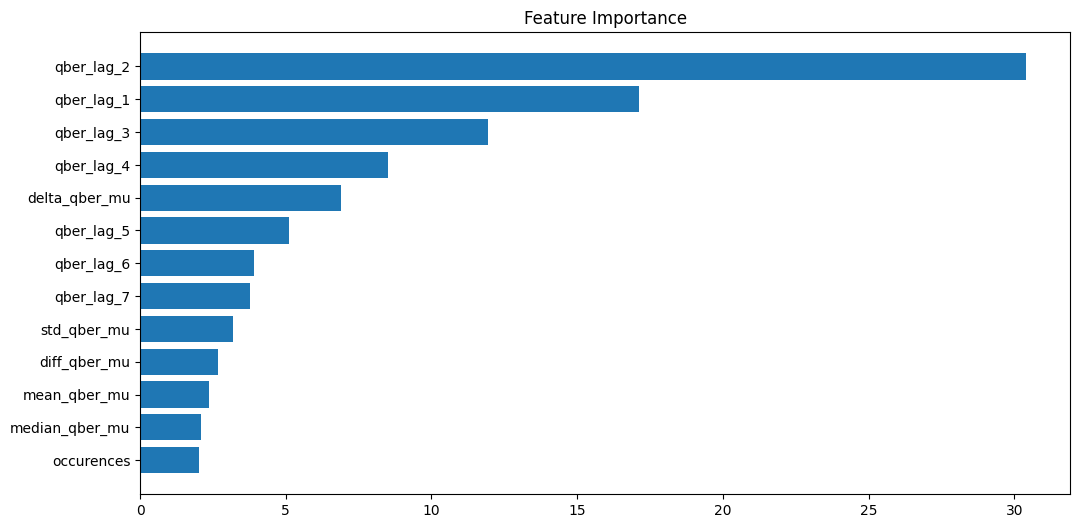

In [181]:
feature_importance = model.boost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.title('Feature Importance')

In [182]:
train_preds = model.predict((train_x_lag, train_x_stat))
test_preds = model.predict((test_x_lag, test_x_stat))
print('Composite EMA + boosting model')
print(f'train R2 = {r2_score(train_y, train_preds):.7f}')
print(f'test R2 = {r2_score(test_y, test_preds):.7f}')
print(f'train MSE = {mean_squared_error(train_y, train_preds):.7f}')
print(f'test MSE = {mean_squared_error(test_y, test_preds):.7f}')
print(f'train RMSE = {mean_squared_error(train_y, train_preds, squared=False):.7f}')
print(f'test RMSE = {mean_squared_error(test_y, test_preds, squared=False):.7f}')
print('-' * 60)

Composite EMA + boosting model
train R2 = 0.7714838
test R2 = 0.6499724
train MSE = 0.0000099
test MSE = 0.0000181
train RMSE = 0.0031507
test RMSE = 0.0042528
------------------------------------------------------------
